# Preprocessing pipeline [dev]

The goal of this pipeline is to produce preprocessed data that is clean enough to be further analyzed in ERP or connectivity analyses. This pipeline is semi-automatic; manual steps are not necessarily required but it is advised to revisit the cleaned epochs. ICA components have to be selected manually.

## Steps
Considering the remarks [here](https://autoreject.github.io/faq.html#should-i-apply-ica-first-or-autoreject-first)


- bandpass filter 0.1-45Hz
- create fixed length epochs
- mark and reject bad data segments with [autoreject](https://www.sciencedirect.com/science/article/abs/pii/S1053811917305013)
- fit ICA on cleaned data segments
- process components
- apply ICA
- run autoreject with more strict thresholds


## Install package requirements

Can be ignored if requirements are already installed.

In [ ]:
!pip install -r ../requirements.txt

## Import packages


```%matplotlib qt``` is for interactive visualization (can be slower); 
switch to ```%matplotlib inline``` for (faster) static plots

In [1]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

import mne
import pandas as pd
import numpy as np 
import autoreject
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
%matplotlib qt

## Load raw data

In [2]:
# Set base path to EEG data
base_path = 'D:\TMS_rewiring'

In [15]:
# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)

if not os.path.exists(interim_path):
    os.makedirs(interim_path)

In [3]:
# Choose a file using a FileChooser widget
fc = FileChooser(base_path)
fc.filter_pattern = '*.vhdr'

display(fc)

FileChooser(path='D:\TMS_rewiring', filename='', title='HTML(value='', layout=Layout(display='none'))', show_h…

In [ ]:
raw_zs = mne.io.read_raw_eeglab(fc.selected)

In [ ]:
raw_zs.plot(n_channels=32)

In [8]:
# Load selected file
raw_file_path = fc.selected
raw_id = Path(raw_file_path).stem
id_split = raw_id.split('_')
subject = id_split[0]
condition = id_split[1]
num_day = [x for x in id_split[-1] if x.isdigit()][0]

raw = mne.io.read_raw_brainvision(raw_file_path, preload=False, verbose=True)

Extracting parameters from D:\TMS_rewiring\Raw_data\24_L\Day3\EEG\24_L_Day3.vhdr...
Setting channel info structure...


In [ ]:
# Visualize sensor positions
raw.plot_sensors(show_names=True, ch_groups='position')

In [ ]:
# Show PSD
raw.plot_psd()

## Event processing

In [9]:
# Read annotations from raw
events_from_annot, _ = mne.events_from_annotations(raw)

event_dict = {83: f'rs_{num_day}',
              91: f'asrt_{num_day}_1',
              93: f'asrt_{num_day}_2',
              95: f'asrt_{num_day}_3',
              97: f'asrt_{num_day}_4',
              99: f'asrt_{num_day}_5',
              101: f'asrt_{num_day}_6',
              87: f'rs_{int(num_day)+1}'}

events_df = pd.DataFrame(data=events_from_annot, columns=['start_time', 'ignore', 'event_id']).drop(columns=['ignore'])
events_df['start_time'] = events_df['start_time'] / raw.info['sfreq']

events_df.head()

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 19', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28', 'Stimulus/S 29', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 38', 'Stimulus/S 39', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 44', 'Stimulus/S 45', 'Stimulus/S 46', 'Stimulus/S 47', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S 83', 'Stimulus/S 84', 'Stimulus/S 85', 'Stimulus/S 87', 'Stimulus/S 88', 'Stimulus/S 89', 'Stimulus/S 91', 'Stimulus/S 92', 'Stimulus/S 93', 'Stimulus/S 94', 'Stimulus/S 95', 'Stimulus/S 96', 'Stimulus/S 97', 'Stimulus/S 98', 'Stimulus/S 99', 'Stimulus/S100', 'Stimulus/S101', 

start_time  event_id
0       0.000     99999
1      65.370         5
2      65.602        85
3      75.428        83
4     375.460        84

In [11]:
block_start_times = []
for epoch_start_num in [91,93,95,97,99,101]:
    sub_df = events_df.iloc[np.array(events_df.index[events_df['event_id'] == epoch_start_num]) + 2]
    if all(sub_df['event_id'].isin([19, 119])):
        block_start_times.extend(sub_df['start_time'].values.tolist())
    else:
        print('Something unexpected happened, check the triggers!')


block_events = events_df[events_df['event_id'].isin([91,93,95,97,99,101])]
block_events['event'] = block_events['event_id'].map(event_dict).fillna(block_events['event_id'])
block_events['real_start_time'] = block_start_times
if num_day != '3':
    try:
        # only seq A
        block_events['end_time'] = events_df[events_df['event_id'] == 52]['start_time'].values
        block_events['sequence'] = 'A'
    except IndexError:
        # only seq B
        block_events['end_time'] = events_df[events_df['event_id'] == 152]['start_time'].values
        block_events['sequence'] = 'B'
else:
    #Az utolsó napon az 1-3-5 epochokban van az A és a 2-4-6 epochokban a B szekvencia a páratlan számú részvevőknél, 
    #és a párosoknál forditva.
    if (int(subject) % 2) == 0:
        block_events.loc[block_events['event_id'].isin([91, 95, 99]), 'sequence'] = 'B'
        block_events.loc[block_events['event_id'].isin([93, 97, 101]), 'sequence'] = 'A'
    else:
        block_events.loc[block_events['event_id'].isin([91, 95, 99]), 'sequence'] = 'A'
        block_events.loc[block_events['event_id'].isin([93, 97, 101]), 'sequence'] = 'B'
    
    block_events['end_time'] = events_df[events_df['event_id'].isin([52, 152])]['start_time'].values
    

c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying t

In [12]:
block_events

start_time  event_id     event  real_start_time sequence  end_time
9        402.018        91  asrt_3_1          403.870        B   532.630
276      555.036        91  asrt_3_1          555.920        B   684.514
539      706.604        91  asrt_3_1          707.338        B   835.898
801      860.974        91  asrt_3_1          862.108        B   990.702
1064    1013.442        91  asrt_3_1         1016.678        B  1145.340
1332    1197.062        93  asrt_3_2         1197.946        A  1326.724
1601    1357.972        93  asrt_3_2         1360.290        A  1489.034
1871    1512.508        93  asrt_3_2         1514.026        A  1642.704
2136    1666.712        93  asrt_3_2         1667.546        A  1796.424
2410    1825.018        93  asrt_3_2         1825.902        A  1954.614
2678    2030.822        95  asrt_3_3         2032.140        B  2160.868
2946    2182.790        95  asrt_3_3         2183.590        B  2312.986
3217    2335.842        95  asrt_3_3         2336.992        B  2465.720
3487    2488.092        95  asrt_3_3         2489.860        B  2618.538
3755    2658.628        95  asrt_3_3         2659.562        B  2788.340
4031    2841.420        97  asrt_3_4         2849.796        A  2978.506
4297    3003.414        97  asrt_3_4         3004.332        A  3132.926
4560    3156.000        97  asrt_3_4         3160.186        A  3288.882
4830    3323.932        97  asrt_3_4         3324.750        A  3453.578
5101    3481.290        97  asrt_3_4         3482.140        A  3610.868
5371    3761.470        99  asrt_3_5         3762.388        B  3891.082
5636    3914.256        99  asrt_3_5         3915.640        B  4044.368
5908    4074.898        99  asrt_3_5         4075.950        B  4204.710
6178    4226.782        99  asrt_3_5         4231.938        B  4360.650
6447    4384.706        99  asrt_3_5         4385.590        B  4514.336
6720    4716.984       101  asrt_3_6         4717.768        A  4846.546
6992    4870.370       101  asrt_3_6         4871.204        A  5000.582
7266    5027.258       101  asrt_3_6         5027.992        A  5157.072
7544    5178.960       101  asrt_3_6         5184.966        A  5313.726
7813    5348.344       101  asrt_3_6         5349.128        A  5478.024

In [13]:
# Create slice from resting events
resting_events = events_df[events_df['event_id'].isin([83, 87])]
resting_end_times = events_df[events_df['event_id'].isin([84, 88])]['start_time'].values

resting_events['end_time'] = resting_end_times

resting_events.reset_index(inplace=True)
resting_events['event'] = resting_events['event_id'].map(event_dict).fillna(resting_events['event_id'])


#block_events['end_time'] = events_df[events_df['event_id'] == 52].rename(columns={'start_time': 'end_time'})['end_time']

#events = block_events.reset_index().append(resting_events)


c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Filtering the raw data

### Bandpass filter 0.1 - 45 Hz

## Cut raw data based on triggers


## I. Resting period

### Create folder for preprocessed files

In [16]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_rs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Create path to interim raw files
interim_raw_path = os.path.join(interim_path, condition, 'raw_rs')
if not os.path.exists(interim_raw_path):
    os.makedirs(interim_raw_path)

### Crop raw data

#### Merge RS segments 

In [17]:
raws = []
for idx, event in resting_events.iterrows():
    raws.append(raw.copy().crop(tmin=event['start_time'], tmax=event['end_time'], include_tmax=True))
    
raw_rs = mne.concatenate_raws(raws)

# how to recover rs at the end?
# resting_events end time - start time
# test = raw_rs_before.copy().crop(tmin=0.0, tmax=300.032, include_tmax=True)
#test2 = raw_rs_before.copy().crop(tmin=300.033, tmax=300.033+300.064, include_tmax=True)
# drop boundary


In [ ]:
# Bandpass filter 1 - 30 Hz
l_freq = 1
h_freq = 30
raw_rs_bandpass_ica = raw_rs.load_data().copy().filter(l_freq=l_freq, h_freq=h_freq)

In [63]:
# Bandpass filter 0.1 - 45 Hz
l_freq = 0.1
h_freq = 45
raw_filtered_rs = raw_rs.load_data().copy().filter(l_freq=l_freq, h_freq=h_freq)

Reading 0 ... 300032  =      0.000 ...   600.064 secs...
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 16501 samples (33.002 sec)



In [ ]:
# rs_start_index = resting_events[resting_events['event_id'] == 83]['start_time'].values[0]
# rs_end_index = resting_events[resting_events['event_id'] == 83]['end_time'].values[0]

# period = resting_events[resting_events['event_id'] == 83]['event'].values[0]

# raw_rs_before = raw_filtered.copy().crop(tmin=rs_start_index, tmax=rs_end_index, include_tmax=True)

# fid = f'{subject}_{condition}_{period}'
# raw_rs_before.info['fid'] = fid

### Visualize raw resting segment (optional)

In [ ]:
# interactively scroll through data
period = '_and_'.join(resting_events['event'].values)
fid = f'{subject}_{condition}_{period}'
raw_rs_bandpass_ica.plot(title=fid,
                   n_channels=32,
                   remove_dc=True)

### 1. Create interim epochs 

In [ ]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 1.0
#OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events = mne.make_fixed_length_events(raw_rs_bandpass_ica,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=0.0)

epochs = mne.Epochs(raw=raw_rs_bandpass_ica,
                    events=events,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

### 2. Run ICA

#### 2.1. Find rejection threshold for ICA

"ICA solutions can be affected by high amplitude artifacts, therefore we recommend to determine a reasonable rejection threshold on which data segments to ignore in the ICA. autoreject (global) can be used exactly for this purpose"


In [ ]:
# find global rejection threshold for ICA
reject = autoreject.get_rejection_threshold(epochs, decim=2)
print(reject)

#### 2.2. Fit ICA on epochs


In [ ]:
n_components = 32
method = 'infomax'

ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, method=method)
ica.fit(epochs, reject=reject, tstep=EPOCH_LENGTH_IN_SECONDS)

#### 2.3. Visualize ICA components on epochs

In [ ]:
ica.plot_components()

In [ ]:
# select the components to exclude, click on their name to visualize sources
ica.plot_sources(epochs, show_scrollbars=True)

#### 2.4. Apply ICA

Note that the components selected above will be excluded in this step!

In [ ]:
raw_rs_ica = ica.apply(raw_filtered_rs)

raw_rs_ica.info['ica_method'] = method
raw_rs_ica.info['ica_n_components'] = n_components
raw_rs_ica.info['ica_n_excluded'] = len(ica.exclude)
raw_rs_ica.info['reject'] = reject["eeg"]

In [ ]:
del raw_filtered_rs

#### 2.5. Recover RS segments

In [ ]:
# Recover RS segments
duration_rs_before, duration_rs_after = resting_events['end_time'] - resting_events['start_time']
raw_rs_ica_1 = raw_rs_ica.copy().crop(tmin=0.0, tmax=duration_rs_before, include_tmax=True)
raw_rs_ica_2 = raw_rs_ica.copy().crop(tmin=duration_rs_before+0.002, tmax=raw_rs_ica.times.max(), include_tmax=True)


In [ ]:
del raw_rs_ica

#### 2.6. Save ICA cleaned raw data

In [ ]:
# save clean epochs
period = resting_events['event'].values[0]
raw_clean_fname = f'{subject}_{condition}_{period}_ICA'
postfix = '-raw.fif.gz'
raw_rs_ica_1.save(os.path.join(interim_raw_path, f'{raw_clean_fname}{postfix}'), overwrite=False)

period = resting_events['event'].values[-1]
raw_clean_fname = f'{subject}_{condition}_{period}_ICA'
postfix = '-raw.fif.gz'
raw_rs_ica_2.save(os.path.join(interim_raw_path, f'{raw_clean_fname}{postfix}'), overwrite=False)

### 3. Create final epochs

#### 3.1. Resting before ASRT

In [ ]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 2.0
OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events_rs_before = mne.make_fixed_length_events(raw_rs_ica_1,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=OVERLAP)

epochs_rs_before = mne.Epochs(raw=raw_rs_ica_1,
                    events=events_rs_before,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

In [ ]:
del raw_rs_ica_1

#### 3.2. Resting after ASRT

In [ ]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 2.0
OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events_rs_after = mne.make_fixed_length_events(raw_rs_ica_2,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=OVERLAP)

epochs_rs_after = mne.Epochs(raw=raw_rs_ica_2,
                    events=events_rs_after,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

In [ ]:
del raw_rs_ica_2

### 4. Run Autoreject
#### 4.1. Resting before ASRT

In [ ]:
# run autoreject on epochs
ar = autoreject.AutoReject(random_state=42, n_jobs=8)#(random_state=42, n_jobs=1, verbose='tqdm')
_, reject_log_rs_before = ar.fit(epochs_rs_before).transform(epochs_rs_before, return_log=True)

#### 4.2. Resting after ASRT

In [ ]:
_, reject_log_rs_after = ar.fit(epochs_rs_after).transform(epochs_rs_after, return_log=True) n_interpolate could be 1

### 5. Exclusion of bad epochs

#### 5.1. Drop bad segments - resting before ASRT

In [ ]:
reject_df = pd.DataFrame(data=reject_log_rs_before.labels, columns=epochs.info['ch_names'])
# 0 : good data segment
# 1 : bad data segment not interpolated
# 2 : bad data segment interpolated
reject_df = reject_df.replace(2, 1)

# drop epochs where more than 20% of sensors were marked as bad
drop_list = reject_df.astype(bool).sum(axis=1) > 12

# merge this list with the originally marked bad epochs
bad_segments = np.logical_or(reject_log_rs_before.bad_epochs, np.array(drop_list))

In [ ]:
epochs_rs_before_dropped = epochs_rs_before.copy().drop(indices=bad_segments, reason='AUTOREJECT', verbose=True)

In [ ]:
# Manual workflow

color_map = {0: None, 1: 'r', 2: (0.6, 0.6, 0.6, 1.0)}
epoch_colors = list()
for epoch_idx, label_epoch in enumerate(reject_log_rs_before.labels):
    if bad_segments[epoch_idx]:
        epoch_color = ['r'] * 64
        epoch_colors.append(epoch_color)
        continue
    epoch_color = list()
    for this_label in label_epoch:
        if not np.isnan(this_label):
            epoch_color.append(color_map[this_label])
        else:
            epoch_color.append(None)
    epoch_colors.append(epoch_color)

period = resting_events['event'].values[0]
fid = f'{subject}_{condition}_{period}'  

epochs_rs_before.plot(title=fid,
                n_channels=32,
                n_epochs=10,
                epoch_colors=epoch_colors)

#### 5.1.2. Manual rejection of epochs (optional)

In [ ]:
period = resting_events['event'].values[0]
fid = f'{subject}_{condition}_{period}'  

epochs_rs_before_dropped.plot(title=fid,
                n_channels=32,
                n_epochs=10)

##### 5.2. Resting after ASRT

In [ ]:
reject_df = pd.DataFrame(data=reject_log_rs_after.labels, columns=epochs.info['ch_names'])
# 0 : good data segment
# 1 : bad data segment not interpolated
# 2 : bad data segment interpolated
reject_df = reject_df.replace(2, 1)

# drop epochs where more than 20% of sensors were marked as bad
drop_list = reject_df.astype(bool).sum(axis=1) > 12

# merge this list with the originally marked bad epochs
bad_segments = np.logical_or(reject_log_rs_after.bad_epochs, np.array(drop_list))

In [ ]:
epochs_rs_after_dropped = epochs_rs_after.copy().drop(indices=bad_segments, reason='AUTOREJECT', verbose=True)

In [ ]:
epoch_colors = list()
for epoch_idx, label_epoch in enumerate(reject_log_rs_after.labels):
    if bad_segments[epoch_idx]:
        epoch_color = ['r'] * 64
        epoch_colors.append(epoch_color)
        continue
    epoch_color = list()
    for this_label in label_epoch:
        if not np.isnan(this_label):
            epoch_color.append(color_map[this_label])
        else:
            epoch_color.append(None)
    epoch_colors.append(epoch_color)

epochs_rs_after.plot(title=fid,
                n_channels=32,
                n_epochs=5,
                epoch_colors=epoch_colors)

In [ ]:
#### 5.2.2. Manual rejection of epochs (optional)

In [ ]:
period = resting_events['event'].values[-1]
fid = f'{subject}_{condition}_{period}'  

epochs_rs_after_dropped.plot(title=fid,
                n_channels=32,
                n_epochs=10)

In [ ]:
from datetime import timezone
# Add information about how many epochs were dropped
epochs_rs_before_dropped.info['dropped'] = [drop for drop in epochs_rs_before_dropped.drop_log if drop]
epochs_rs_before_dropped.info['n_dropped'] = len([drop for drop in epochs_rs_before_dropped.drop_log if drop])
epochs_rs_before_dropped.info['file_create_date'] = datetime.now(timezone.utc)

# Save clean epochs
period = resting_events['event'].values[0]
fid = f'{subject}_{condition}_{period}'

epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'

epochs_rs_before_dropped.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
# Add information about how many epochs were dropped
epochs_rs_after_dropped.info['dropped'] = [drop for drop in epochs_rs_after_dropped.drop_log if drop]
epochs_rs_after_dropped.info['n_dropped'] = len([drop for drop in epochs_rs_after_dropped.drop_log if drop])
epochs_rs_after_dropped.info['file_create_date'] = datetime.now(timezone.utc)

# Save clean epochs
period = resting_events['event'].values[-1]
fid = f'{subject}_{condition}_{period}'

epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'

epochs_rs_after_dropped.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
del epochs_rs_before, epochs_rs_after

### 6. Interpolate bad channels

In [ ]:
manual_bad_channels = epochs_rs_before_dropped.info['bads']
epochs_rs_before_dropped.interpolate_bads(reset_bads=True)

ransac = autoreject.Ransac(verbose='progressbar', n_jobs=1)
epochs_rs_before_ransac = ransac.fit_transform(epochs_rs_before_dropped)

epochs_rs_before_ransac.info['rancac_bad_channels'] = ransac.bad_chs_
epochs_rs_before_ransac.info['manual_bad_channels'] = manual_bad_channels

In [ ]:
# set average reference
epochs_rs_before_ransac.set_eeg_reference()

In [ ]:
manual_bad_channels = epochs_rs_after_dropped.info['bads']
epochs_rs_after_dropped.interpolate_bads(reset_bads=True)

ransac = autoreject.Ransac(verbose='progressbar', n_jobs=1)
epochs_rs_after_ransac = ransac.fit_transform(epochs_rs_after_dropped)

epochs_rs_after_ransac.info['rancac_bad_channels'] = ransac.bad_chs_
epochs_rs_after_ransac.info['manual_bad_channels'] = manual_bad_channels

In [ ]:
# set average reference
epochs_rs_after_ransac.set_eeg_reference()

In [ ]:
del epochs_rs_before_dropped, epochs_rs_after_dropped

### 7. Save clean data

In [ ]:
# Add information about how many epochs were dropped
epochs_rs_before_ransac.info['dropped'] = [drop for drop in epochs_rs_before_ransac.drop_log if drop]
epochs_rs_before_ransac.info['n_dropped'] = len([drop for drop in epochs_rs_before_ransac.drop_log if drop])

# Save clean epochs
period = resting_events['event'].values[0]
fid = f'{subject}_{condition}_{period}'

epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'

epochs_rs_before_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
# Add information about how many epochs were dropped
epochs_rs_after_ransac.info['dropped'] = [drop for drop in epochs_rs_after_ransac.drop_log if drop]
epochs_rs_after_ransac.info['n_dropped'] = len([drop for drop in epochs_rs_after_ransac.drop_log if drop])

# Save clean epochs
period = resting_events['event'].values[-1]
fid = f'{subject}_{condition}_{period}'

epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'

epochs_rs_after_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_rs_after_ransac.plot()

## II. ASRT

In [18]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_asrt')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Create path to interim raw files
interim_raw_path = os.path.join(interim_path, condition, 'raw_asrt')
if not os.path.exists(interim_raw_path):
    os.makedirs(interim_raw_path)

In [19]:
block_events.head(5)

start_time  event_id     event  real_start_time sequence  end_time
9        402.018        91  asrt_3_1          403.870        B   532.630
276      555.036        91  asrt_3_1          555.920        B   684.514
539      706.604        91  asrt_3_1          707.338        B   835.898
801      860.974        91  asrt_3_1          862.108        B   990.702
1064    1013.442        91  asrt_3_1         1016.678        B  1145.340

In [53]:
raws = []
for idx, event in block_events.iterrows():
    raws.append(raw.copy().crop(tmin=event['start_time'], tmax=event['end_time'], include_tmax=True))
    
raw_asrt = mne.concatenate_raws(raws)

In [56]:
# Bandpass filter 1 - 30 Hz
l_freq = 1
h_freq = 30
raw_asrt_bandpass_ica = raw_asrt.load_data().copy().filter(l_freq=l_freq, h_freq=h_freq)

Filtering raw data in 30 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 sec)



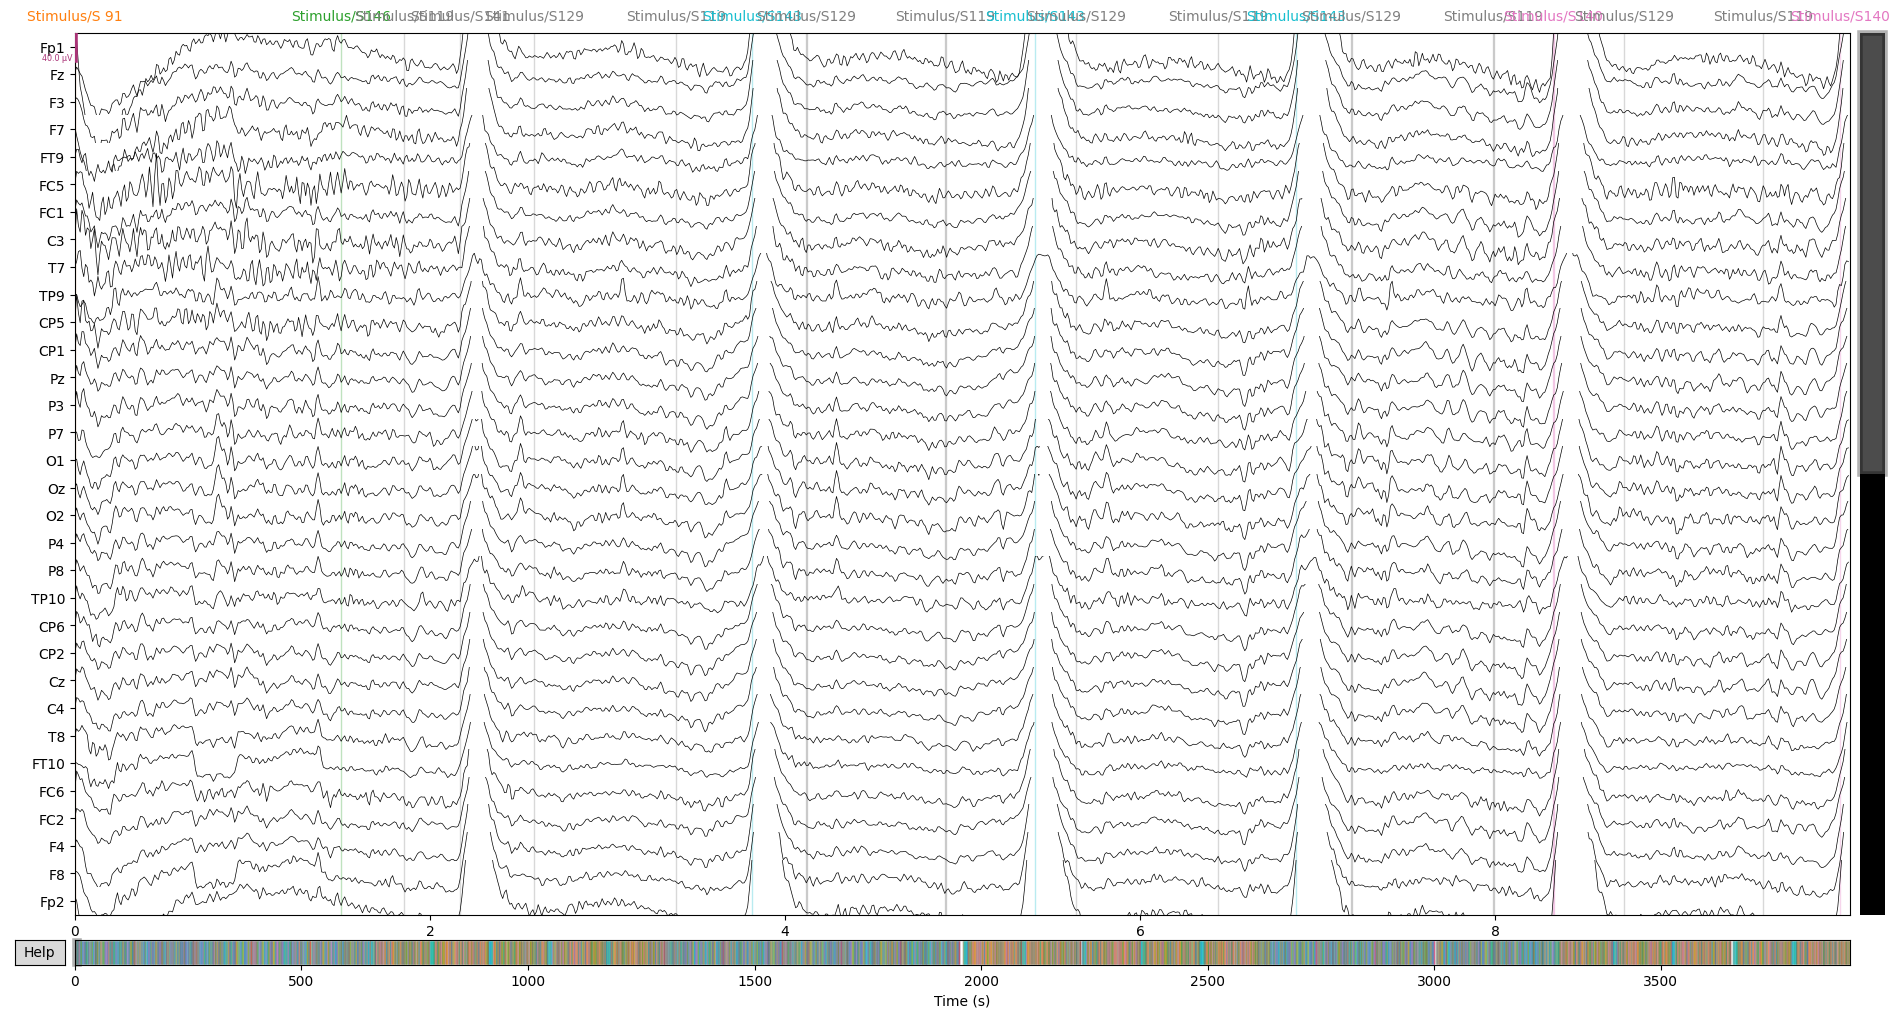

Channels marked as bad: none


In [26]:
# interactively scroll through data
# interactively scroll through data
#period = '_and_'.join(resting_events['event'].values)
fid = f'{subject}_{condition}_asrt_{num_day}'
raw_asrt_bandpass_ica.plot(title=fid,
                   n_channels=32,
                   remove_dc=True)

In [58]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 1.0
#OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events = mne.make_fixed_length_events(raw_asrt_bandpass_ica,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=0.0)

epochs = mne.Epochs(raw=raw_asrt_bandpass_ica,
                    events=events,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

Not setting metadata
Not setting metadata
3917 matching events found
No baseline correction applied
0 projection items activated
Loading data for 3917 events and 500 original time points ...
0 bad epochs dropped


In [30]:
del raw_asrt_bandpass_ica

In [50]:
# find global rejection threshold for ICA
reject = autoreject.get_rejection_threshold(epochs, decim=2)

Estimating rejection dictionary for eeg


In [29]:
n_components = 32
method = 'infomax'

ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, method=method)
ica.fit(epochs, reject=reject, tstep=EPOCH_LENGTH_IN_SECONDS)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 32 components
 


c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\mne\preprocessing\infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Fitting ICA took 666.3s.


<ICA | epochs decomposition, fit (infomax): 1944000 samples, 32 components, channels used: "eeg">

In [31]:
ica.plot_components()

[<Figure size 975x942 with 20 Axes>, <Figure size 975x706.5 with 12 Axes>]

Not setting metadata
Not setting metadata
3888 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


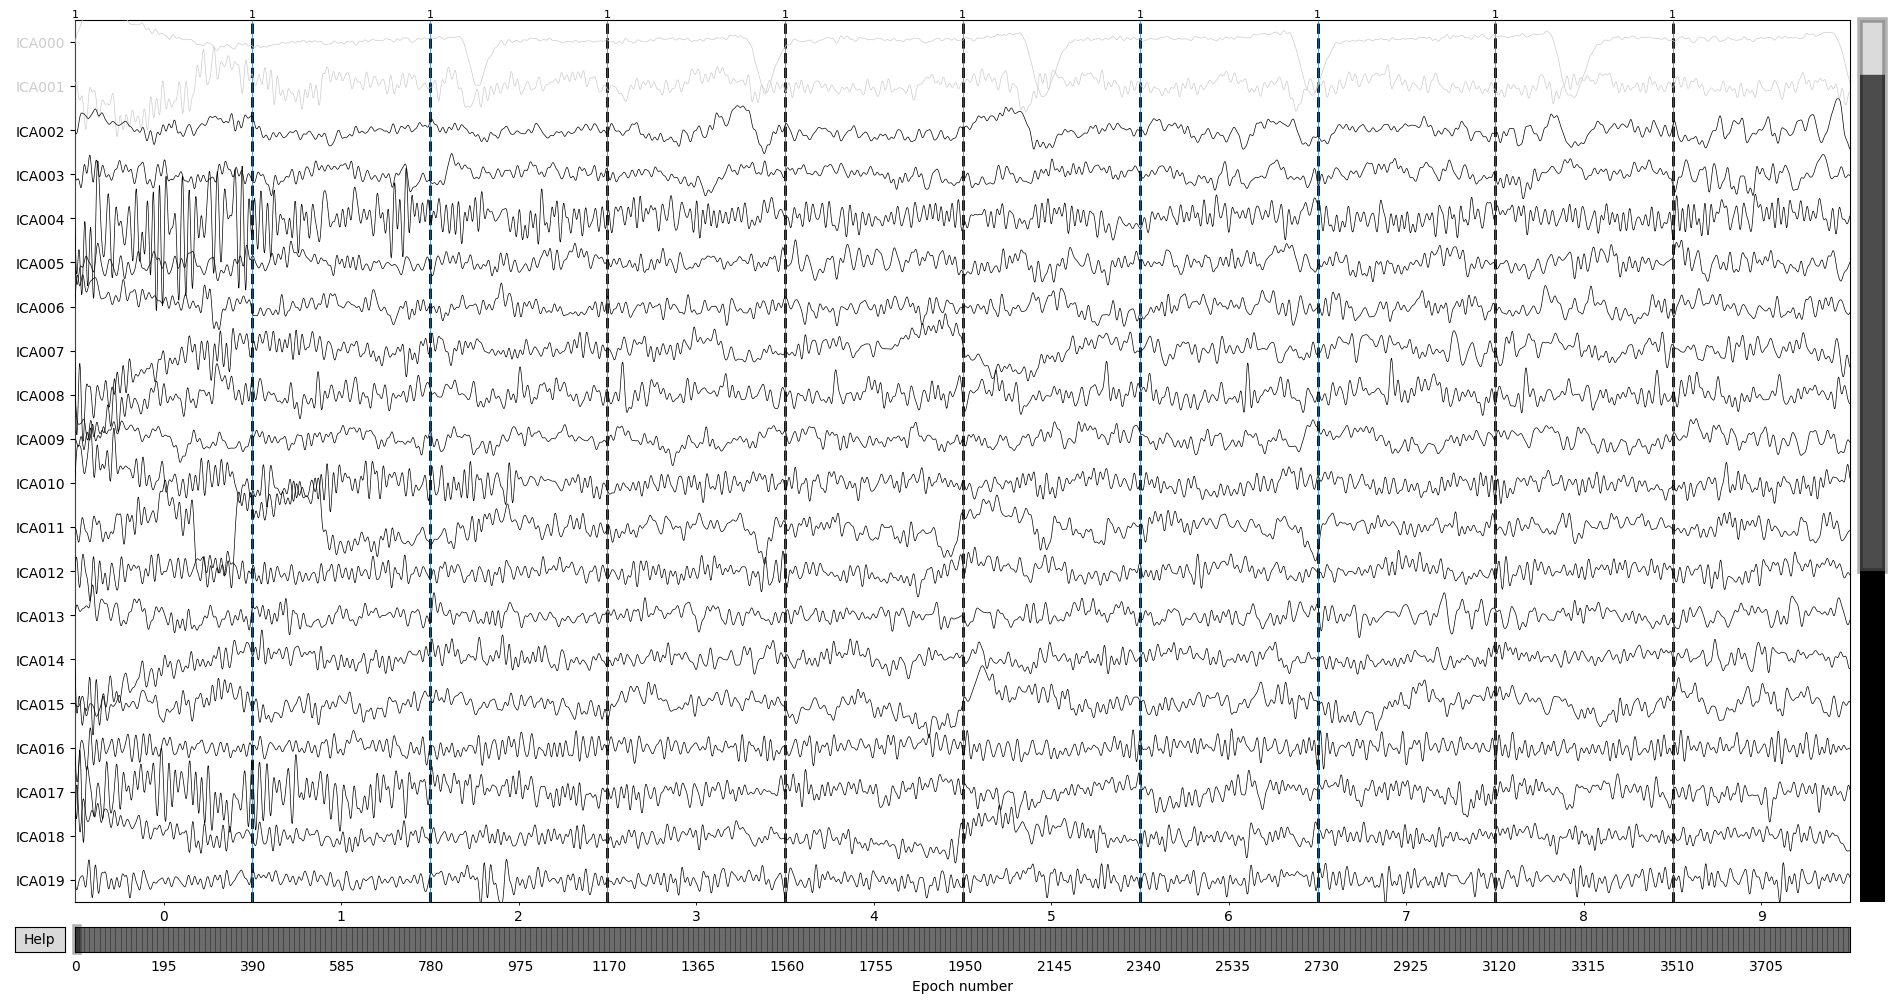

In [37]:
# select the components to exclude, click on their name to visualize sources
ica.plot_sources(epochs, show_scrollbars=True, start=0, stop=15)

In [38]:
del epochs

In [64]:
# Bandpass filter 0.1 - 45 Hz
l_freq = 0.1
h_freq = 45
raw_filtered_asrt = raw_asrt.load_data().copy().filter(l_freq=l_freq, h_freq=h_freq)

Filtering raw data in 30 contiguous segments
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 16501 samples (33.002 sec)



In [65]:
raw_asrt_ica = ica.apply(raw_filtered_asrt)

raw_asrt_ica.info['ica_method'] = method
raw_asrt_ica.info['ica_n_components'] = n_components
raw_asrt_ica.info['ica_reject'] = reject['eeg']
raw_asrt_ica.info['ica_n_excluded'] = len(ica.exclude)

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


In [ ]:
del raw_filtered_asrt

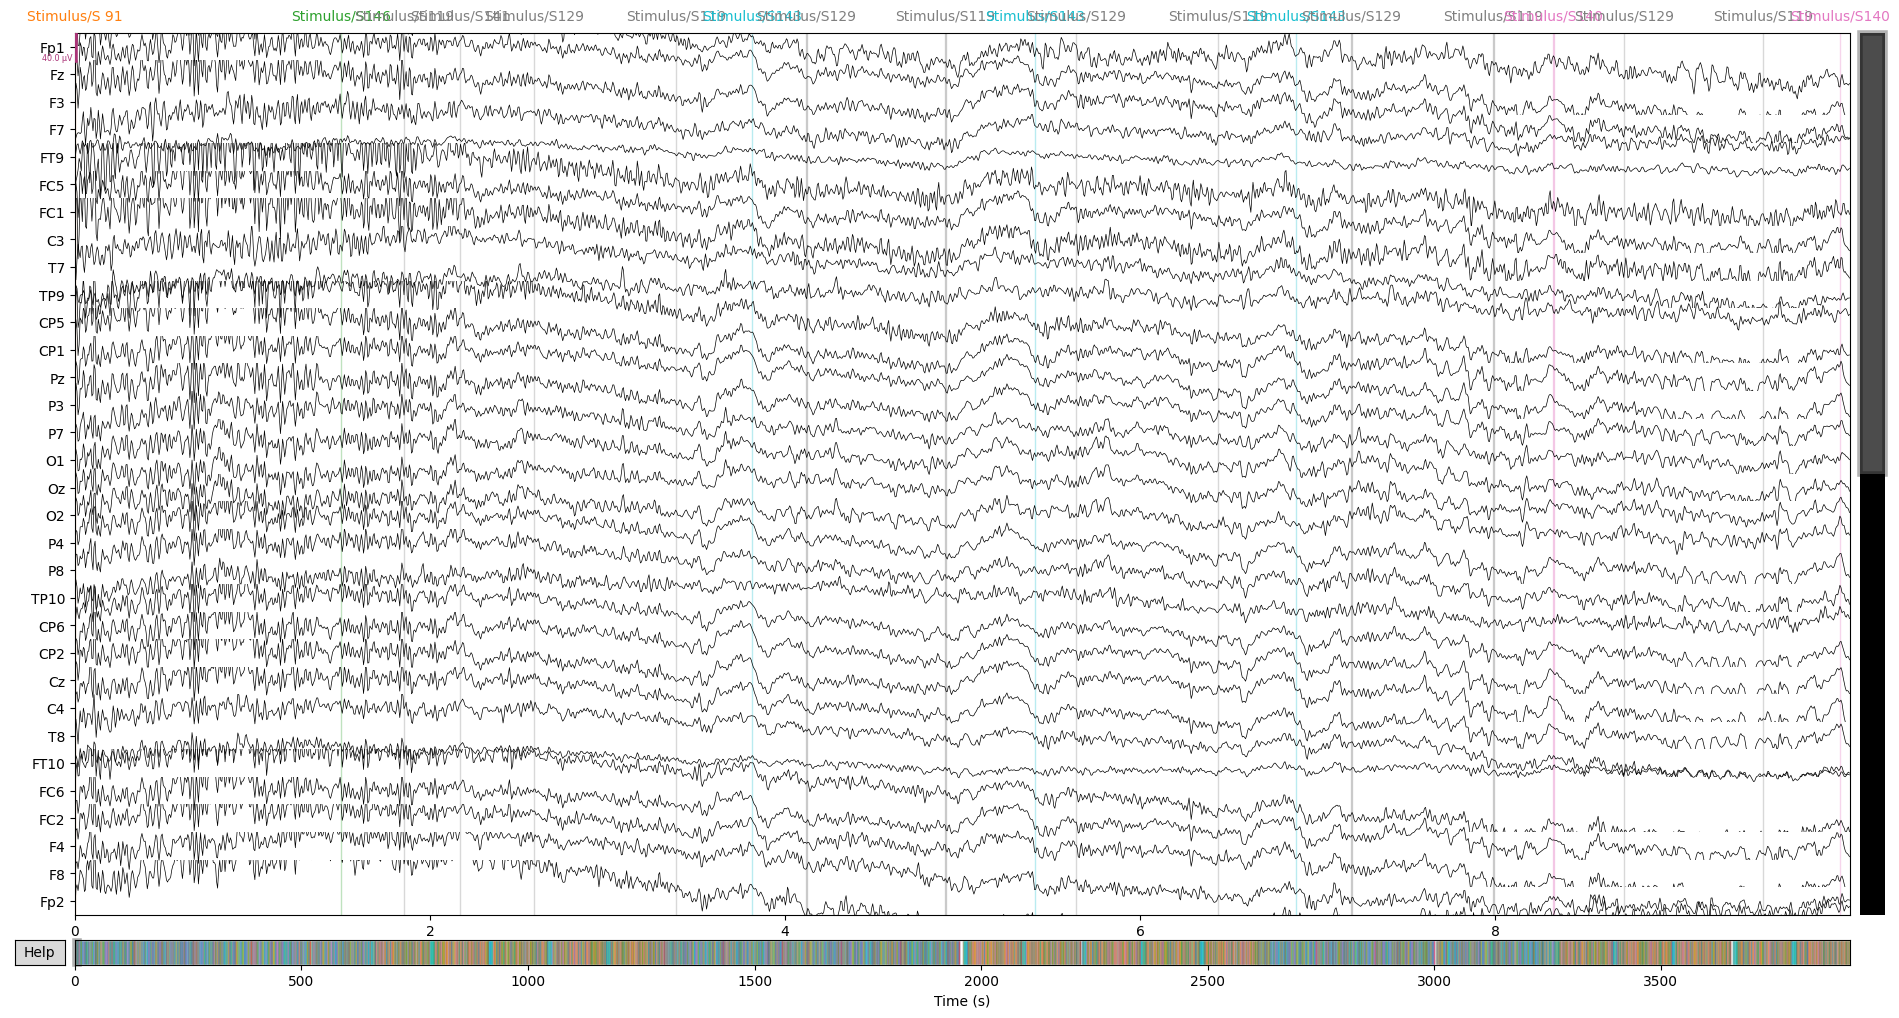

Channels marked as bad: none


In [66]:
# # interactively scroll through data
raw_asrt_ica.plot(title=fid,
              n_channels=32,
              remove_dc=True)

In [67]:
# save clean epochs

raw_clean_fname = f'{fid}_ICA'
postfix = '-raw.fif.gz'
raw_asrt_ica.save(os.path.join(interim_raw_path, f'{raw_clean_fname}{postfix}'), overwrite=True)

Overwriting existing file.
Writing D:\TMS_rewiring\preprocessed\L\raw_asrt\24_L_asrt_3_ICA-raw.fif.gz
Closing D:\TMS_rewiring\preprocessed\L\raw_asrt\24_L_asrt_3_ICA-raw.fif.gz
[done]


In [68]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 2.0
#OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events = mne.make_fixed_length_events(raw_asrt_ica,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=0.0)

epochs = mne.Epochs(raw=raw_asrt_ica,
                    events=events,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    reject_by_annotation=False,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

Not setting metadata
Not setting metadata
1958 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1958 events and 1000 original time points ...
0 bad epochs dropped


In [ ]:
# start_times = [events[idx][0] / raw.info['sfreq'] for idx in range(len(events)-1) if bad_segments[idx]]

# raw_filtered_rs_ica.annotations.append(onset=start_times,
#                                  duration=[(events[1][0] - events[0][0]) / raw.info['sfreq']] * len(start_times),
#                                  description='BAD_autoreject',)


In [69]:
# run autoreject on epochs
ar = autoreject.AutoReject(random_state=42, n_jobs=8)#(random_state=42, n_jobs=1, verbose='tqdm')
_, reject_log_asrt = ar.fit(epochs).transform(epochs, return_log=True)

Running autoreject on ch_type=eeg








Estimated consensus=0.10 and n_interpolate=1


TypeError: transform() got an unexpected keyword argument 'n_interpolate'

In [70]:
reject_df = pd.DataFrame(data=reject_log_asrt.labels, columns=epochs.info['ch_names'])
# 0 : good data segment
# 1 : bad data segment not interpolated
# 2 : bad data segment interpolated
reject_df = reject_df.replace(2, 1)

# drop epochs where more than 20% of sensors were marked as bad
drop_list = reject_df.astype(bool).sum(axis=1) > 12

# merge this list with the originally marked bad epochs
bad_segments = np.logical_or(reject_log_asrt.bad_epochs, np.array(drop_list))

In [71]:
reject_df.shape

(1958, 64)

In [72]:
start_times = [events[idx][0] / raw.info['sfreq'] for idx in range(epochs.events.shape[0]) if bad_segments[idx]]

raw_asrt_ica.annotations.append(onset=start_times,
                                  duration=[(events[1][0] - events[0][0]) / raw.info['sfreq']] * len(start_times),
                                 description='BAD_autoreject',)


<Annotations | 9778 segments: BAD boundary (29), BAD_autoreject (1783), ...>

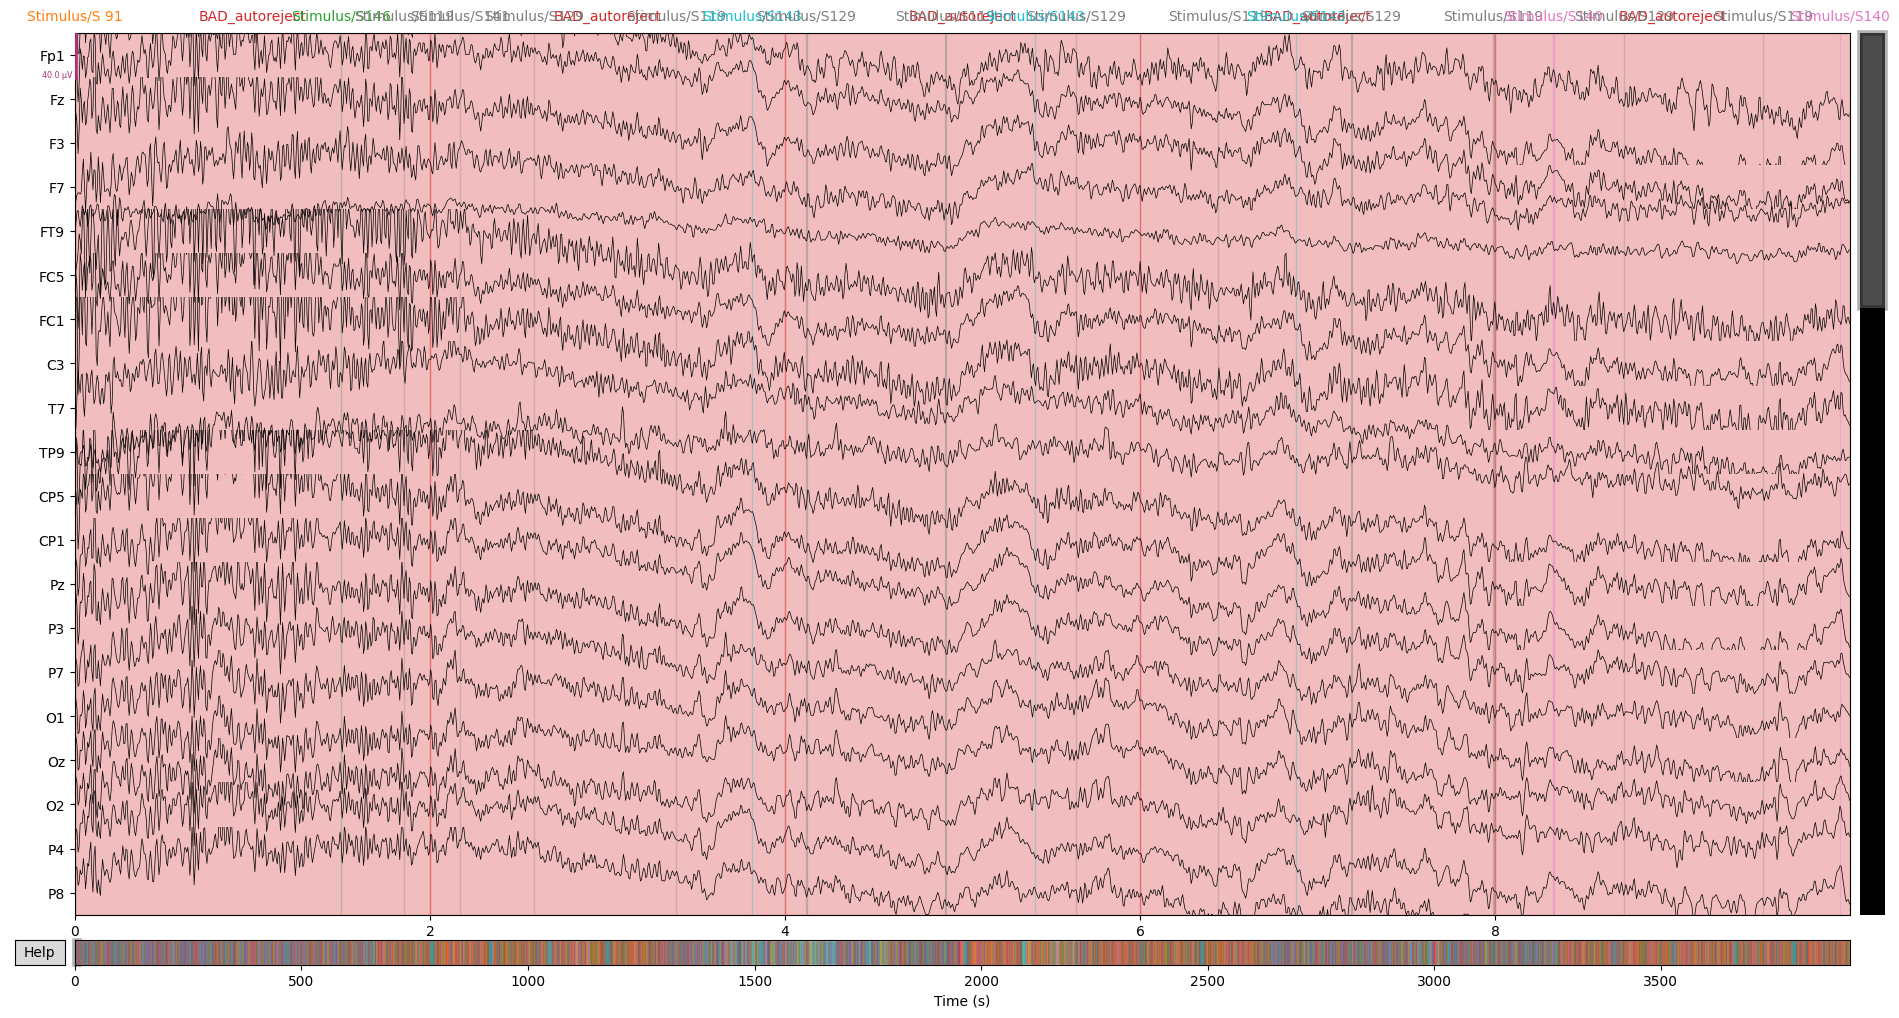

In [73]:
raw_asrt_ica.plot()

In [51]:
# save clean epochs
raw_clean_fname = f'{fid}_ICA'
postfix = '-raw.fif.gz'
raw_asrt_ica.save(os.path.join(interim_raw_path, f'{raw_clean_fname}{postfix}'), overwrite=True)

NameError: name 'raw_asrt_ica' is not defined

In [ ]:
# Day 3
raws_A = []
raws_B = []

for idx, event in block_events.iterrows():
    if event['sequence'] == 'A':
        raws_A.append(raw_asrt_ica.copy().crop(tmin=event['start_time'], tmax=event['end_time'], include_tmax=True))
    else:
        raws_B.append(raw_asrt_ica.copy().crop(tmin=event['start_time'], tmax=event['end_time'], include_tmax=True))
    
raw_asrt_A = mne.concatenate_raws(raws_A)
raw_asrt_B = mne.concatenate_raws(raws_B)

In [ ]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 2.0
OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events_asrt = mne.make_fixed_length_events(raw_asrt_ica,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=OVERLAP)

epochs_asrt = mne.Epochs(raw=raw_asrt_ica.copy().filter(1,30),
                    events=events_asrt,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    reject_by_annotation=True,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)


new_events = mne.merge_events(events_from_annot, event_list, new_id=1, replace_events=False)
epochs_stim = mne.Epochs(raw=raw_filtered_asrt_ica,
                    events=new_events,
                    event_id=1,
                    picks='eeg',
                    reject_by_annotation=True,
                    baseline=None,
                    tmin=0.,
                    tmax=2,
                    preload=False)

In [ ]:
epochs_stim

In [ ]:
new_events = mne.merge_events(events_from_annot, [10,11,12,13,14,15,16], new_id=1, replace_events=False)

In [ ]:
datetime.utcnow()

In [ ]:
import datetime


# Add information about how many epochs were dropped
epochs_asrt.info['dropped'] = [drop for drop in epochs_asrt.drop_log if drop]
epochs_asrt.info['n_dropped'] = len([drop for drop in epochs_asrt.drop_log if drop])
epochs_asrt.info['file_create_date'] = datetime.datetime.now(datetime.timezone.utc)

# Save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'

epochs_asrt.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_asrt.plot(n_epochs=5)

In [ ]:
manual_bad_channels = epochs_asrt.info['bads']
epochs_asrt.interpolate_bads(reset_bads=True)

ransac = autoreject.Ransac(verbose='progressbar', n_jobs=1)
epochs_asrt_ransac = ransac.fit_transform(epochs_asrt)

epochs_asrt_ransac.info['rancac_bad_channels'] = ransac.bad_chs_
epochs_asrt_ransac.info['manual_bad_channels'] = manual_bad_channels

In [ ]:
epochs_asrt_ransac.set_eeg_reference()

In [ ]:
manual_bad_channels = epochs_asrt.info['bads']
epochs_asrt.interpolate_bads(reset_bads=True)

In [ ]:
epochs_asrt_ransac.info['manual_bad_channels'] = manual_bad_channels
# # save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
print(epochs_clean_fname)
postfix = '-epo.fif.gz'
epochs_asrt_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_asrt_ransac.info['rancac_bad_channels']

In [ ]:
epochs_asrt_ransac.plot(n_epochs=10,
                       n_channels=32)

In [ ]:
# # Add information about how many epochs were dropped
# epochs_clean.info['dropped'] = [drop for drop in epochs_clean.drop_log if drop]
# epochs_clean.info['n_dropped'] = len([drop for drop in epochs_clean.drop_log if drop])
# epochs_clean.info['file_create_date'] = datetime.utcnow()

# # Save clean epochs
# epochs_clean_fname = f'{fid}_ICA_autoreject'
# postfix = '-epo.fif.gz'

# epochs_clean.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'))

In [ ]:
#epochs_ar_dropped = epochs_ar.copy().drop(indices=drop_list, reason='AUTOREJECT', verbose=True)